## Emis3D example: Creating a radiation distribution


In this example, we will go over the process of creating a radiation distribution from the availble functions found in `main/radDist.py`. These functions create a mock radiation distribution within the tokamak, which is then observed by the bolometers to produce a simulated signal for each channel. The simulated signals are then saved to a file which is later compred to the observed signal during the minimization process in Emis3D. 

### Overall process

We will create one radDist in this example and view the output. Once you are familar with the process, please use the `runProgramScrips/make_radDists.py` to create many of them in parallel. 

1. Create a config file under `/inputs/{tokamakName}/{shot}/`, when you run `make_radDists.py` in the future.
2. Specify the input parameters below (tokamak name and path + name to the config file)
3. If rLimits and zLimits are blank in the config file (aka []), you'll need to load the Tokamak class, which will then load a gfile or the wall config file for that tokamak (see below for how to do that)
4. An important thing to note is that each instance of calling the a radDist function will initilize the tokamak class before or when calling self.build(). This is where the program gets the bolometer information. It is important to test the tokamak class and plot each bolometer prior to creating a radDist. 

In [1]:
import os
import sys

# Ensure the parent directory is in the system path for module imports
sys.path.append(os.path.abspath("../.."))

import matplotlib.pyplot as plt
import numpy as np
from raysect.core import Point2D

import main.Util_radDist as Util_radDist
from main.Globals import *
from main.Tokamak import Tokamak
from main.Util import config_loader, point3d_to_rz

### Input parameters

Specify the tokamak name and where the radDist configuration file is

In [2]:
tokamakName = "DIII-D"
configFileName = "elongatedRing_config_example.yaml" # path to the config file
   

---
That is it! The rest of the code below is run in the `make_radDists.py` program. It is included for this to be a complete example. 

---

### Load the tokamak class, if rArray and zArray are blank

This is used to find the R and z limits for the radDist grid, the `make_radDist.py` program will loop over each of these points, but this is not done in this example since we are creating one radDist

In [3]:
# --- Load the configuration file
config = config_loader(pathFileName=configFileName)

if config is not None:
    # --- Load the tokamak if rArray and zArray are blank in the configuration file
    if len(config['GRID']["rLimits"]) == 0 or len(config['GRID']["zLimits"]) == 0:
        print("Creating R, z grid using the tokamak information...")
        # --- Need to load the tokamak to get wall information
        # !!!! IMPORTANT !!!!
        # The code will look for the DIII-D_settings.yaml file in /tokamaks/DIII-D/
        # Make sure that the file is updated there! 
        tok = Tokamak(
            tokamakName=tokamakName,
            mode="Analysis",
            reflections=False,
            eqFileName=config["eqFileName"],
        )
        rzArray = Util_radDist.callRZGridTokamak(
            tok,
            numRgrid=config["GRID"]["NumRStartGrid"],
            numZgrid=config["GRID"]["NumZStartGrid"],
        )
    else:
        rzArray = Util_radDist.createRZGrid(
            rLimits=config["GRID"]["rLimits"],
            zLimits=config["GRID"]["zLimits"],
            numRgrid=config["GRID"]["NumRStartGrid"],
            numZgrid=config["GRID"]["NumZStartGrid"],
            wallcurve=None,
        )

### Run the program

Here we are just running the program while ensuring that only one radDist is created. This is a bit different than what is in the `make_radDists.py` program. 

Note: This will probably take 2 min to run

In [5]:
# --- Set polSigma, elongation, rotationAngle to single values for this testing script
if config is not None:
    config["polSigma"] = config["polSigmas"][0]
    config["elongation"] = config["elongations"][0]
    config["rotationAngle"] = config["rotationAngles"][0]

# --- Ensure that we are only creating one radDist in this testing script
arg_list = []
if config is not None:
    arg_list = [(val, config) for val in rzArray]

    arg_list = arg_list[0]

    if config['distType'] == 'Helical':
        rD = Util_radDist.radDist_Helical_parallel_return_radDist(arg_list)
    elif config['distType'] == 'ElongatedRing':
        rD = Util_radDist.radDist_ElongatedRing_parallel_return_radDist(arg_list)
    else:
        print("radDist type not recognized.")

radDist type not recognized.


Plotting script below. We will need to create the tokamak class to get plot the wall information. 

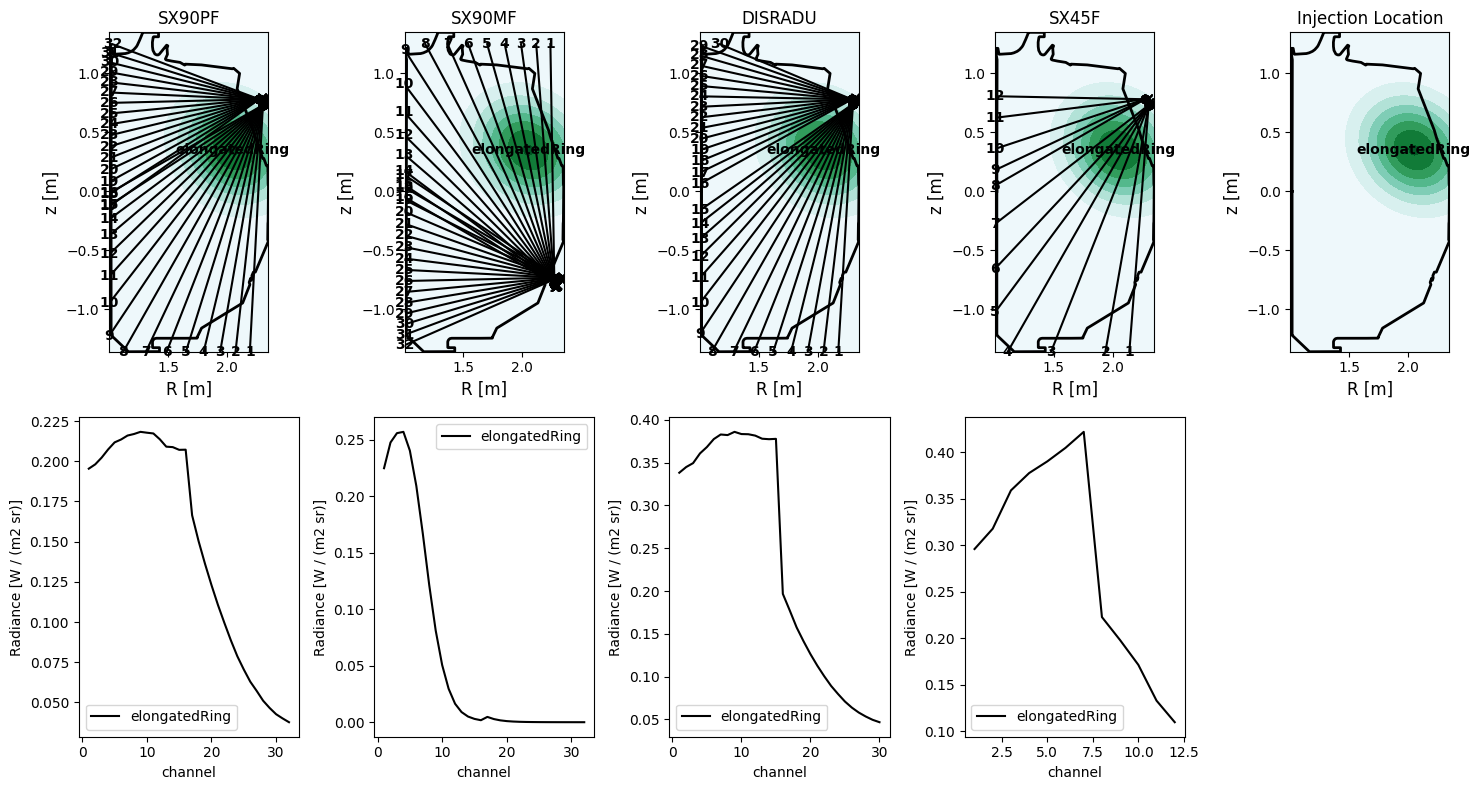

In [10]:
tok = Tokamak(
            tokamakName=tokamakName,
            mode="Analysis",
            reflections=False,
            eqFileName=None,
        )

# --- TODO: Update this list and plotting script so it will automatically group them based on location,
# this is needed since each bolometer array is treated individually
bolometerNames = [
    ["SX90PF_UP", "SX90PF_DOWN"],
    ["SX90MF_UP", "SX90MF_DOWN"],
    ["DISRADU_UP", "DISRADU_DOWN"],
    ["SX45F_UP", "SX45F_DOWN"],
]

# --- Find the location of each bolometer
bolo_tokamak = []
if rD is not None and hasattr(rD, "tokamak") and hasattr(rD.tokamak, "bolometers"):
    for bolo in rD.tokamak.bolometers:  # type: ignore
        bolo_tokamak.append(bolo.name)
else:
    raise AttributeError("rD or rD.tokamak.bolometers is not properly initialized.")


# --- Plot each individual bolometer
if config is not None and rD is not None:
    num_rows = len(bolometerNames) + 1
    f = plt.figure(figsize=(15, 8))

    for ii, boloGroup in enumerate(bolometerNames):
        f_top = f.add_subplot(2, num_rows, ii + 1)
        tok._plot_first_wall(f_top)
        for bolo in boloGroup:
            indx_ = bolo_tokamak.index(bolo)
            for foil in rD.tokamak.bolometers[indx_].bolometer_camera:  # type: ignore
                slit_centre = foil.slit.centre_point
                slit_centre_rz = point3d_to_rz(slit_centre)
                f_top.plot(slit_centre_rz[0], slit_centre_rz[1], "ko")
                origin, hit, _ = foil.trace_sightline()
                centre_rz = point3d_to_rz(foil.centre_point)
                f_top.plot(centre_rz[0], centre_rz[1], "kx")
                origin_rz = point3d_to_rz(origin)
                hit_rz = point3d_to_rz(hit)
                f_top.plot([origin_rz[0], hit_rz[0]], [origin_rz[1], hit_rz[1]], "k")
                f_top.text(
                    hit_rz[0],
                    hit_rz[1],
                    str(int(foil.name[-2:])),
                    fontsize="10",
                    ha="center",
                    va="center",
                    weight="bold",
                )
        f_top.set_title(boloGroup[0].split("_")[0])
        # --- Plot the radDist
        # Use the first bolometer in the group to get indx_
        indx_plot = bolo_tokamak.index(boloGroup[0])
        rD.plotCrossSection(
            phi=np.deg2rad(
                int(
                    rD.tokamak.bolometers[indx_plot].info["CAMERA_POSITION_R_Z_PHI"][2]
                )
            ),
            ax=f_top,
        )

    # --- Plot SPI injection location
    f_top = f.add_subplot(2, num_rows, len(bolometerNames) + 1)
    tok._plot_first_wall(f_top)
    rD.plotCrossSection(phi=np.deg2rad(config["injectionLocation"]), ax=f_top)
    f_top.set_title("Injection Location")

    # --- Plot the observed emissivities

    colors = ["black", "purple", "blue", "green", "orange", "red"]

    for ii, boloGroup in enumerate(bolometerNames):
        f_top = f.add_subplot(2, num_rows, ii + 6)
        for qq, emissionName in enumerate(rD.info["emissionNames"]):
            # --- Group the data
            data_ = []
            chan_ = []
            for jj, bolo in enumerate(boloGroup):
                indx_ = bolo_tokamak.index(bolo)
                ch_tags = rD.tokamak.bolometers[indx_].info["CHANNEL_TAGS"]
                c_ = []
                for ch in ch_tags:  # type: ignore
                    c_.append(int(ch[-2:]))

                data_ += rD.data[rD.info["units"]][emissionName][bolo]
                chan_ += c_

            # --- Sort the channel list in ascending order
            inds = np.array(chan_).argsort()
            f_top.plot(
                np.array(chan_)[inds],
                np.array(data_)[inds],
                color=colors[qq],
                label=emissionName,
            )

        f_top.legend()
        f_top.set_ylabel(f"{rD.data['units']}")
        f_top.set_xlabel("channel")

    plt.tight_layout()
    plt.show()
